## 1. Setup
First, you must clone the `ssm` repository and install all of the dependencies. The `ssm` package we are using can be found, along with installation instructions, [here](https://github.com/lindermanlab/ssm.git). 

The line `import ssm` imports the package for use. Here, we have also imported a few other packages for plotting.

In [1]:
import os
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sglm import hmmUtils, utils, qUtils
import ssm

%load_ext autoreload
%autoreload 2

npr.seed(42)

#### 1a. Import your data

In [2]:
data_ = pd.read_csv(r'C:\Users\janet\Documents\Behavior_samp_data\FreelyMoving_6nback_021024_wDOB_wrecordDF.csv')

In [3]:
probs = '80-20'
ages = [1, 2, 3] # 1: 2 months, 2: 4 months, 3: 6 months, 4: 12 months
trial_based = 1
filtered_data = data_[(data_['Condition'] == probs) & (data_['Age_Group'].isin(ages)) & (data_['Trial_based'] == trial_based)]

In [4]:
#choice as -1 or 1
filtered_data.loc[:, '1_Port'] = filtered_data['1_Port'].replace(0, -1)
filtered_data.loc[:, '2_Port'] = filtered_data['2_Port'].replace(0, -1)
filtered_data.loc[:, '3_Port'] = filtered_data['3_Port'].replace(0, -1)

In [5]:
#add columns for interaction between reward and choice
filtered_data.loc[:, '1_ChoiceReward'] = filtered_data['1_Port'] * filtered_data['1_Reward']
filtered_data.loc[:, '2_ChoiceReward'] = filtered_data['2_Port'] * filtered_data['2_Reward']
filtered_data.loc[:, '3_ChoiceReward'] = filtered_data['3_Port'] * filtered_data['3_Reward']

C:\Users\janet\AppData\Local\Temp\ipykernel_7276\1374730130.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.loc[:, '1_ChoiceReward'] = filtered_data['1_Port'] * filtered_data['1_Reward']
C:\Users\janet\AppData\Local\Temp\ipykernel_7276\1374730130.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.loc[:, '2_ChoiceReward'] = filtered_data['2_Port'] * filtered_data['2_Reward']
C:\Users\janet\AppData\Local\Temp\ipykernel_7276\1374730130.py:4: SettingWithCopyWarning: 
A value is 

In [ ]:
#add up animals in unique age groups
age_group = filtered_data.groupby('Age_Group')

#add up in each age group
age_group_counts = age_group['Mouse ID'].unique()
age_group_counts = age_group_counts.apply(lambda x: len(x))
age_group_counts

In [ ]:
age_group_counts = age_group['Mouse ID'].unique()
age_group_counts

## 2. Input Driven Observations
We create a HMM with input-driven observations and 'standard' (stationary) transitions with the following line:  
```python
        ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", observation_kwargs=dict(C=num_categories), transitions="standard")
```

As in Ashwood et al. (2020), we are going to model an animal's binary choice data during a decision-making task, so we will set `num_categories=2` because the animal only has two options available to it. We will also set `obs_dim = 1` because the dimensionality of the observation data is 1 (if we were also modeling, for example, the binned reaction time of the animal, we could set `obs_dim = 2`).  For the sake of simplicity, we will assume that an animal's choice in a particular state is only affected by the external stimulus associated with that particular trial, and its innate choice bias. Thus, we will set `input_dim = 2` and we will simulate input data that resembles sequences of stimuli in what follows.  In Ashwood et al. (2020), they found that many mice used 3 decision-making states when performing 2AFC tasks. We will, thus, set `num_states = 3`.

## 2a. Set up your model and initialize parameters

In [ ]:
# Model Inputs
num_states = [4] # number of discrete states, can be a single value or list
obs_dim =  1 # number of observed dimensions, 1 for just reward, 2 if you had something like reaction time
num_categories = 2 # number of categories for the output

# set sigma and alpha for the prior on the weights, set kappa for "sticky" transitions
prior_sigma = 2
prior_alpha = 2
#kappa = 0

### 2b. Option 1 - Data and param set up for global fitting

In [ ]:
probs = '80-20'
train_split = 0.80
seed = np.random.randint(1000)

# Get train/test session IDs

train_ids, test_ids = train_test_split(filtered_data['Session ID'].unique(), 
                                      train_size=train_split, random_state=seed)

print('You have {} training sessions and {} test sessions.'.format(len(train_ids), len(test_ids)))

In [ ]:
# create train_data list of dataframes for each session
train_data = [filtered_data[filtered_data['Session ID'] == i] for i in train_ids]
test_data = [filtered_data[filtered_data['Session ID'] == i] for i in test_ids]

In [ ]:
# Extracting specific columns and creating variables for model input GLOBAL
x_cols = ['1_Port', '2_Port', '3_Port', '1_ChoiceReward', '2_ChoiceReward', '3_ChoiceReward']

# loop through train_data and test_data to get x and y data
train_data_x = [i[x_cols].values for i in train_data]
test_data_x = [i[x_cols].values for i in test_data]

# number of trials in each train_data_x and test_data_x
train_data_sessions = [len(i) for i in train_data_x]
test_data_sessions = [len(i) for i in test_data_x]

num_trials_per_train_sess = len(train_data_sessions)
num_trials_per_test_sess = len(test_data_sessions)

# Extract 'Decision' from train_data and test_data
choices = [i['Decision'] for i in train_data]
test_data_y = [i['Decision'] for i in test_data]

# Reshape and convert data to integer type
choices = [i['Decision'].values.reshape(-1, 1).astype(int) for i in train_data]
test_data_y = [i['Decision'].values.reshape(-1, 1).astype(int) for i in test_data]


### 2c. (Option 1) - Fit the model globally with cross validation 

In [ ]:
observations = "input_driven_obs"
transitions = "standard"
iters = 500

global_model_list, global_ll_list, global_train_scores, global_test_scores = hmmUtils.global_fit(
    train_data_x, choices, num_states, obs_dim, observations, num_categories, prior_sigma, transitions, prior_alpha, iters)


In [ ]:
global_weights = global_model_list[0].observations.params

In [ ]:
#save stationary model list, train and test scores, and LL list
import pickle

model_params = {'num_states': num_states,
                'obs_dim': obs_dim,
                'num_categories': num_categories,
                'prior_sigma': prior_sigma,
                'prior_alpha': prior_alpha,
                'observations': observations,
                'transitions': transitions,
                'x_cols': x_cols,
                'data_filter': 'age_group:3, probs:80-20, trial_based:1',
                'notes': "used 3 nback data, 80-20 prob, 80-20 split, reward is 0-1, choice is -1-1, global fit"}

data_splits = {'train_split': train_split,
               'train_ids': train_ids,
               'test_ids': test_ids,
               }

#create dictionary for pickle
model_dict = {'model_params' : model_params,
                'data_splits': data_splits,
                   'model_list': global_model_list,
                   'model_train_scores': global_train_scores,
                   'model_test_scores': global_test_scores,
                   'model_ll_list': global_ll_list, 
                   'model_weights': global_weights}

#save dictionary in pickle file
save_dir = r'C:\Users\janet\Documents\Behavior_samp_data\models'
pickle.dump(model_dict, open(os.path.join(save_dir, 'global_fit_' + f'{num_states}state.pkl'), 'wb'))



### 2d. Option 2 - Data and param set up for individual fits 

In [ ]:
#create separate datasets for each mouse
mice = filtered_data['Mouse ID'].unique()

mouse_dfs = []

for mouse in mice:
    mouse_data = filtered_data[filtered_data['Mouse ID'] == mouse]
    mouse_dfs.append({'mouse': mouse, 'data': mouse_data})    


In [ ]:
#split each mouse's data into train and test sets
train_split = 0.8
seed = np.random.randint(1000)

#get train and test session IDs
train_ids = []
test_ids = []
splits = []

for mouse in mouse_dfs:
    mouse_train, mouse_test = train_test_split(mouse['data']['Session ID'].unique(), 
                                               train_size=train_split, random_state=seed)
    train_ids.append(mouse_train)
    test_ids.append(mouse_test)
    splits.append({'mouse': mouse['mouse'], 'train': len(mouse_train), 'test': len(mouse_test)})

#split data
train_data = []
test_data = []


for i, mouse in enumerate(mouse_dfs):
    train_data.append({'mouse': mouse, 'data': [[mouse['data'][mouse['data']['Session ID'] == ii]] for ii in train_ids[i]]})
    test_data.append({'mouse': mouse, 'data': [[mouse['data'][mouse['data']['Session ID'] == ii]] for ii in test_ids[i]]})
        

In [ ]:
#looping through each mouse to extract data and set model inputs - INDIVIDUAL
x_cols = ['1_Port', '2_Port', '3_Port', '1_ChoiceReward', '2_ChoiceReward', '3_ChoiceReward']

train_data_x, test_data_x, train_choices, test_choices, train_data_trials, test_data_trials = hmmUtils.create_animal_datalist(train_data, test_data, x_cols)

### 2e. Option 2 - Fit the model across individual animals with cross validation 

In [ ]:
observations = "input_driven_obs"
transitions = "standard"
iters = 500

mouse_model_list, mouse_ll_list, mouse_train_scores, mouse_test_scores = hmmUtils.animal_fit(
    train_data_x, train_choices, num_states, obs_dim, observations, num_categories, prior_sigma, transitions, prior_alpha, iters)

In [ ]:
## loop through each mouse and find generative weights and append to list
mouse_weights = []
for i in range(len(mouse_model_list)):
    mouse_weights.append({'mouse': train_data_x[i]['mouse'], 'weights': mouse_model_list[i]['glmhmm'].observations.params})

In [ ]:
#save stationary model list, train and test scores, and LL list
import pickle

model_params = {'num_states': num_states,
                'obs_dim': obs_dim,
                'num_categories': num_categories,
                'prior_sigma': prior_sigma,
                'prior_alpha': prior_alpha,
                'observations': observations,
                'transitions': transitions,
                'x_cols': x_cols,
                'data_filter': 'age_group:3, probs:80-20, trial_based:1',
                'notes': "used 3 nback data, 80-20 prob, 80-20 split, reward is 0-1, choice is -1-1, animal fits"}

data_splits = {'train_split': train_split,
               'train_ids': train_ids,
               'test_ids': test_ids,
               'splits': splits}

#create dictionary for pickle
model_dict = {'model_params' : model_params,
                'data_splits': data_splits,
                   'model_list': mouse_model_list,
                   'model_train_scores': mouse_train_scores,
                   'model_test_scores': mouse_test_scores,
                   'model_ll_list': mouse_ll_list, 
                   'weights': mouse_weights}

#save dictionary in pickle file
save_dir = r'C:\Users\janet\Documents\Behavior_samp_data\models'
pickle.dump(model_dict, open(os.path.join(save_dir, 'animal_fits_'+f'{num_states}state.pkl'), 'wb'))



## 3. Plot the results - here, we will plot the GLM weights for the global fit and the individual fits

In [ ]:
num_states_2plot = num_states[-1]

cols = ['#ff7f00', '#4daf4a', '#377eb8', '#e41a1c']

if num_states_2plot == 1:
    # Plot the GLM weights for each input regressor for each mouse 
    fig = plt.figure(figsize=(7, 2.5), dpi=80, facecolor='w', edgecolor='k')
    for i in range(len(mouse_weights)):
        for j in range(num_states_2plot):
            plt.plot(-mouse_weights[i]['weights'][j,0,:], lw=2,
                color=cols[j], marker = 'o', markersize = 5)
            plt.plot(-global_weights[j,0,:], lw=2, color='black', linestyle='--')
    plt.legend(loc="upper right")
    plt.xticks(np.arange(len(x_cols)), x_cols, rotation=45, fontsize = 10)
    plt.ylabel("GLM weight", fontsize = 15)
    plt.xlabel("Inputs", fontsize = 15)
    plt.xlim((0, len(x_cols)))
    plt.title('HMM fits - ' + f'{num_states_2plot}' + 'state')
else:
    ## Plot the GLM weights for each input regressor for each mouse use subplots for each state
    fig, axs = plt.subplots(num_states_2plot, 1, figsize=(12, 18), dpi=80, facecolor='w', edgecolor='k')
    axs = axs.ravel()
    for i in range(len(mouse_weights)):
        for j in range(num_states_2plot):
            axs[j].plot(-mouse_weights[i]['weights'][j,0,:], lw=2,
                color=cols[j], marker = 'o', markersize = 5)
            axs[j].plot(-global_weights[j,0,:], lw=2, color='black', linestyle='--')
            axs[j].set_title('State' + str(j + 1), fontsize = 15)
            axs[j].set_ylabel("GLM weight", fontsize = 15)
            axs[j].set_xlabel("Inputs", fontsize = 15)
            axs[j].set_xlim((0, len(x_cols)))
            axs[j].set_xticks(np.arange(len(x_cols)))
            axs[j].set_xticklabels(x_cols, rotation=45, fontsize = 10)
    plt.legend(loc="upper right")


## Now that we have trained the models, we will compare them with some QC metrics and plot the results.

### First, lets load our models and data

In [46]:
## Load previously saved model
import pickle
save_dir = r'C:\Users\janet\Documents\Behavior_samp_data\models'

global_model_1 = pickle.load(open(os.path.join(save_dir, '1-state', 'global_fit_[1]state.pkl'), 'rb'))
global_model_2 = pickle.load(open(os.path.join(save_dir, '2-state', 'global_fit_[2]state.pkl'), 'rb'))
global_model_3 = pickle.load(open(os.path.join(save_dir, '3-state', 'global_fit_[3]state.pkl'), 'rb'))
global_model_4 = pickle.load(open(os.path.join(save_dir, '4-state', 'global_fit_[4]state.pkl'), 'rb'))

animal_model_1 = pickle.load(open(os.path.join(save_dir, '1-state', 'animal_fits_[1]state.pkl'), 'rb'))
animal_model_2 = pickle.load(open(os.path.join(save_dir, '2-state', 'animal_fits_[2]state.pkl'), 'rb'))
animal_model_3 = pickle.load(open(os.path.join(save_dir, '3-state', 'animal_fits_[3]state.pkl'), 'rb'))
animal_model_4 = pickle.load(open(os.path.join(save_dir, '4-state', 'animal_fits_[4]state.pkl'), 'rb'))

#Put models in list for easy access
global_models = [global_model_1, global_model_2, global_model_3, global_model_4]
animal_models = [animal_model_1, animal_model_2, animal_model_3, animal_model_4]

### We will normalize the test log likelihoods and plot them

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Global fits - normalized test LL')

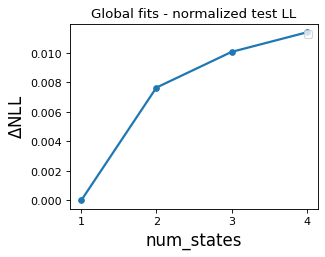

In [47]:
# loop through global models and determine normalized test LL
global_test_ll = []
for i in range(len(global_models)):
    num_states = global_models[i]['model_params']['num_states']
    sessions = global_models[i]['data_splits']['test_ids']
    sess_df = filtered_data[filtered_data['Session ID'].isin(sessions)]
    trials = len(sess_df)

    test_choices = sess_df['Decision'].to_numpy().reshape(-1, 1).astype(int)
    x_cols = global_models[i]['model_params']['x_cols']
    test_inpts = sess_df[x_cols].to_numpy()
    test_ll = global_models[i]['model_list'][0].log_likelihood(test_choices, test_inpts)
    norm_ll = [test_ll/trials]
    global_test_ll.append({'num_states': num_states, 'norm_ll': norm_ll})

    #Plot normalized test LL for each global model against number of states
num_states_list = [1, 2, 3, 4]

fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
norm_ll_vals_list = []
delta_ll_vals_list = []

for i in range(len(global_test_ll)):
    norm_ll_vals = global_test_ll[i]['norm_ll'][0]
    norm_ll_vals_list.append(norm_ll_vals)

for s in range(len(global_test_ll)):
    delta_vals = norm_ll_vals_list[s] - norm_ll_vals_list[0]
    delta_ll_vals_list.append(delta_vals)

plt.plot(num_states_list, delta_ll_vals_list, marker = 'o', markersize = 5, lw=2)
plt.legend(loc="upper right")
plt.ylabel("$\Delta$NLL", fontsize = 15)
plt.xlabel("num_states", fontsize = 15)
plt.xticks(np.arange(1, 5))
plt.title('Global fits - normalized test LL')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Animal fits - normalized test LL')

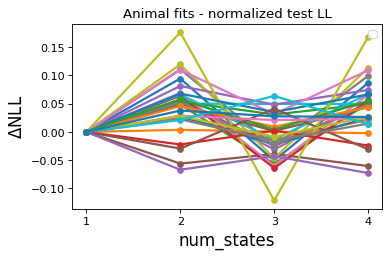

In [48]:
animal_test_ll = []

for i in range(len(animal_models)):
    num_states = animal_models[i]['model_params']['num_states']
    x_cols = animal_models[i]['model_params']['x_cols']
    for j, mouse in enumerate(animal_models[i]['model_list']):
        sessions = animal_models[i]['data_splits']['test_ids'][0:]
        sess_list = []  
        test_choices = []  
        trials = []  
        test_inpts = []  
        #create dataframe for each session in sessions appended to list
        for sess in sessions:
            sess_df = filtered_data[filtered_data['Session ID'].isin(sess)]
            choices = sess_df['Decision'].to_numpy().reshape(-1, 1).astype(int)
            inpts = sess_df[x_cols].to_numpy()
            sess_len = len(sess_df)
            sess_list.append(sess_df)
            test_choices.append(choices)
            trials.append(sess_len)
            test_inpts.append(inpts)        
        test_ll = animal_models[i]['model_list'][j]['glmhmm'].log_likelihood(test_choices[j], test_inpts[j])
        #normalize log likelihoods by number of trials
        norm_ll = [test_ll/trials[j]]
        animal_test_ll.append({'num_states': num_states, 'mouse': mouse['mouse'], 'norm_ll': norm_ll})

#group data by mouse and then find delta NLL
grouped_data = {}
for item in animal_test_ll:
    mouse = item['mouse']
    if mouse not in grouped_data:
        grouped_data[mouse] = []
    grouped_data[mouse].append(item)
    
#Loop through each mouse and find the delta NLL in grouped_data
animal_delta_ll_vals = []
for mouse in grouped_data:
    d_ll = []
    # Extract the norm_ll value of the first item for reference
    ref_norm_ll = grouped_data[mouse][0]['norm_ll']
    for item in grouped_data[mouse]:
        delta = ref_norm_ll[0] - item['norm_ll'][0]
        d_ll.append(delta)
    animal_delta_ll_vals.append({'mouse': mouse, 'delta_ll': d_ll})


num_states_list = [1, 2, 3, 4]
#Plot delta NLL for each mouse against number of states
fig = plt.figure(figsize=(5, 3), dpi=80, facecolor='w', edgecolor='k')
for i in range(len(animal_delta_ll_vals)):
    plt.plot(num_states_list, animal_delta_ll_vals[i]['delta_ll'], marker = 'o', markersize = 5, lw=2)
plt.legend(loc="upper right")
plt.ylabel("$\Delta$NLL", fontsize = 15)
plt.xlabel("num_states", fontsize = 15)
plt.xticks(np.arange(1, 5))
plt.title('Animal fits - normalized test LL')

Text(0.5, 1.0, 'Average Animal fits vs global fits - normalized test LL')

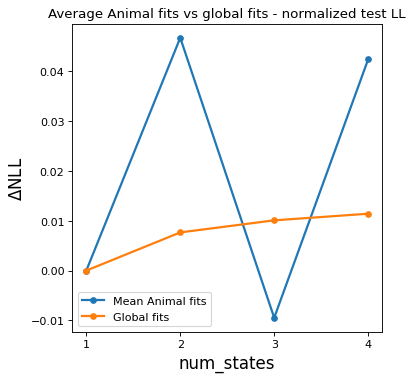

In [49]:
#average delta NLL across each same index for each mouse
avg_delta_ll = []
for i in range(len(animal_delta_ll_vals[0]['delta_ll'])):
    avg = np.mean([x['delta_ll'][i] for x in animal_delta_ll_vals])
    avg_delta_ll.append(avg)

#plot average delta NLL for each mouse with global delta NLL
fig = plt.figure(figsize=(5, 5), dpi=80, facecolor='w', edgecolor='k')
plt.plot(num_states_list, avg_delta_ll, marker = 'o', markersize = 5, lw=2, label = 'Mean Animal fits')
plt.plot(num_states_list, delta_ll_vals_list, marker = 'o', markersize = 5, lw=2, label = 'Global fits')
plt.legend(loc="lower left")
plt.ylabel("$\Delta$NLL", fontsize = 15)
plt.xlabel("num_states", fontsize = 15)
plt.xticks(np.arange(1, 5))
plt.title('Average Animal fits vs global fits - normalized test LL')

### Now, we will look at the Cross-validated log likelihoods for each model

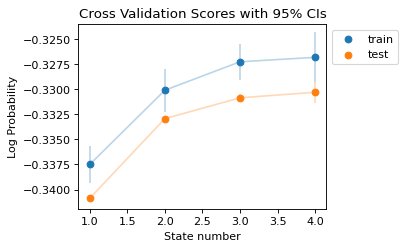

In [50]:
#compare k states
states = []
scores ={'train': [], 'test': []}

#loop through each global model and append train and test scores to list
for item in global_models:
    train_scores = item['model_train_scores'][0] 
    test_scores = item['model_test_scores'][0] 
    states.append(item['model_params']['num_states'][0])  
    scores['train'].append(train_scores)
    scores['test'].append(test_scores)

qUtils.compare_k_states(scores, states)

c:\Users\janet\Documents\GitHub\glm_and_glmhmm\sglm\qUtils.py:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(4, 3), dpi=80)


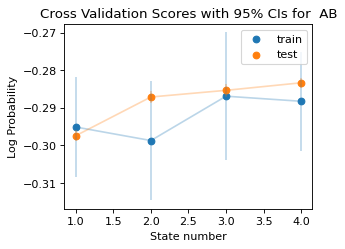

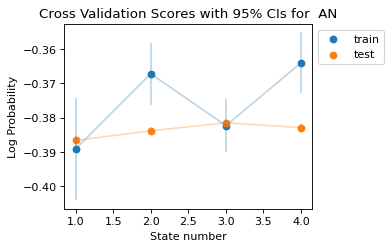

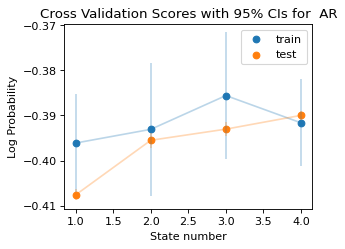

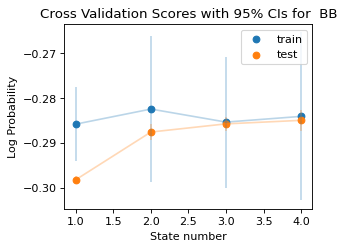

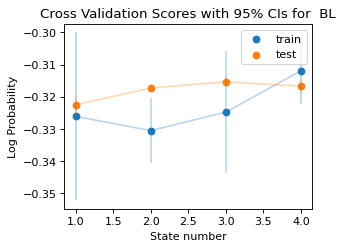

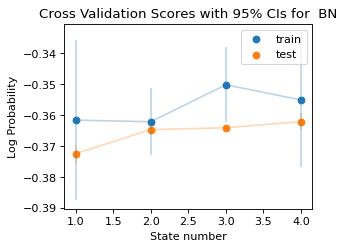

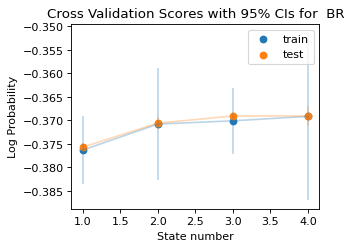

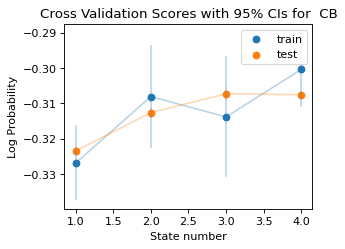

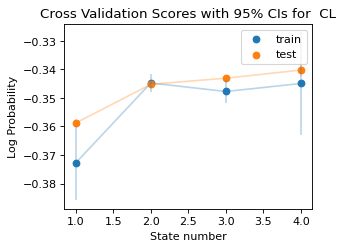

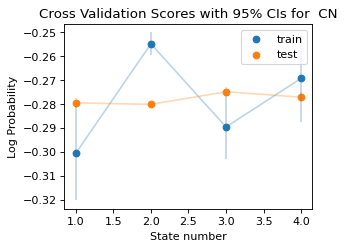

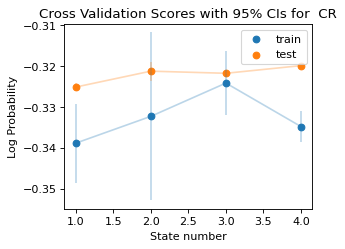

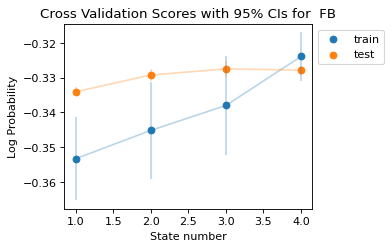

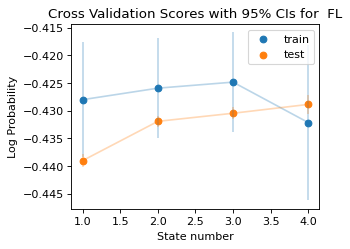

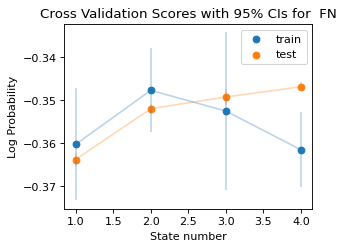

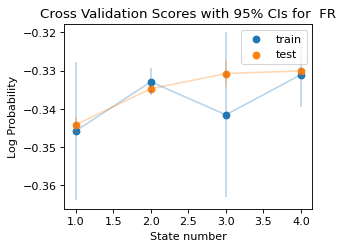

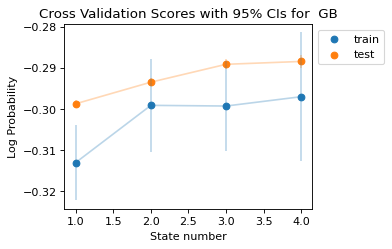

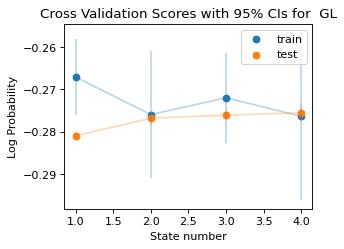

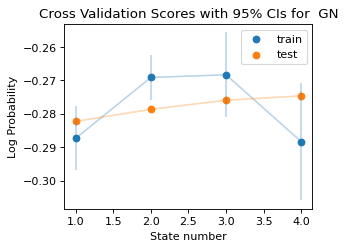

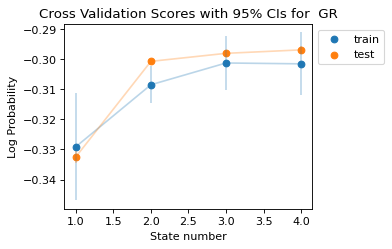

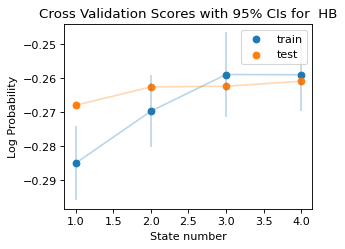

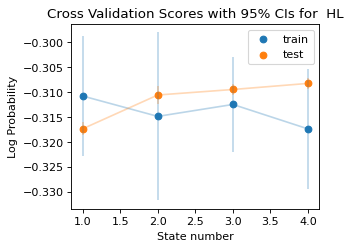

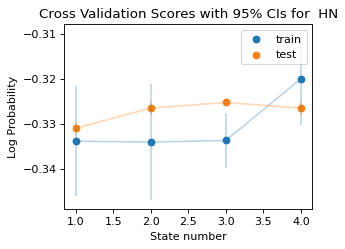

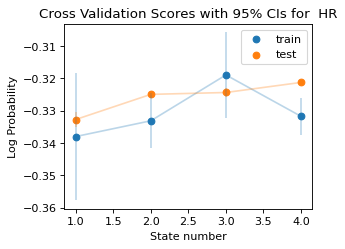

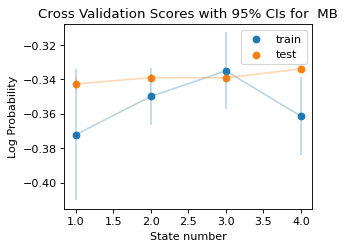

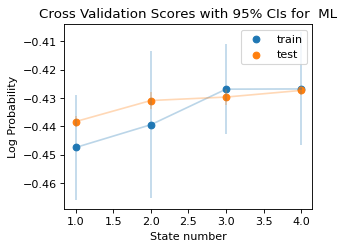

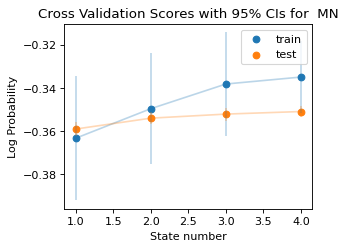

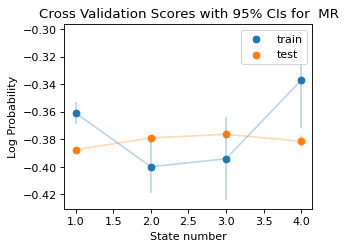

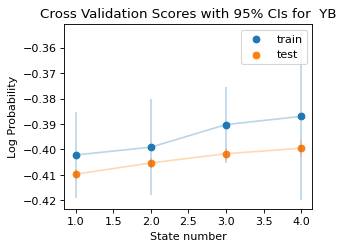

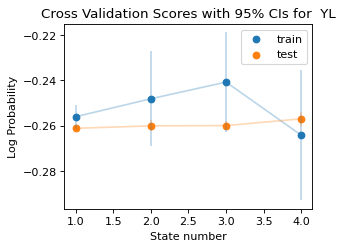

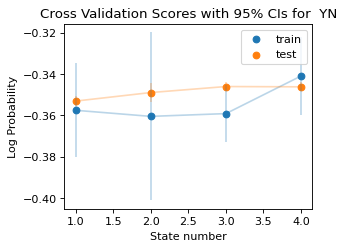

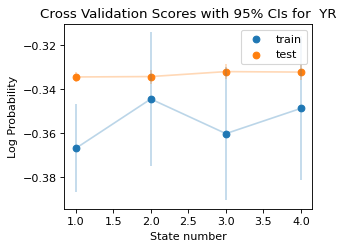

In [51]:
#compare k states for animal fits

states = []
scores ={'train': [], 'test': []}

for item in animal_models:
    states.append(item['model_params']['num_states'][0])
    for i in range(len(item['model_train_scores'])):
        animal = item['model_train_scores'][i]['mouse']
        train_scores = item['model_train_scores'][i]['scores']
        scores['train'].append({'mouse': animal, 'num_states': item['model_params']['num_states'][0],
                                 'score': train_scores})
    for i in range(len(item['model_test_scores'])):
        animal = item['model_test_scores'][i]['mouse']
        test_scores = item['model_test_scores'][i]['scores']
        scores['test'].append({'mouse': animal, 'num_states': item['model_params']['num_states'][0],
                                 'score': test_scores})

qUtils.compare_k_states(scores, states, multi_animal=True)

### Predict state sequences for each model

In [52]:
# get train and test data for each global model
global_train_x = []
global_test_x = []
global_train_choices = []
global_test_choices = []

for i in range(len(global_models)):
    x_cols = global_models[i]['model_params']['x_cols']
    train_data = global_models[i]['data_splits']['train_ids']
    test_data = global_models[i]['data_splits']['test_ids']
    train_data = filtered_data[filtered_data['Session ID'].isin(train_data)]
    test_data = filtered_data[filtered_data['Session ID'].isin(test_data)]
    global_train_x.append(train_data[x_cols].to_numpy())
    global_test_x.append(test_data[x_cols].to_numpy())
    global_train_choices.append(train_data['Decision'].to_numpy().reshape(-1, 1).astype(int))
    global_test_choices.append(test_data['Decision'].to_numpy().reshape(-1, 1).astype(int))

In [53]:
## predict state sequence for each global model
global_train_states, global_test_states = qUtils.predict_state(global_train_x, global_test_x, 
                                                               global_train_choices, global_test_choices, 
                                                               global_models)

In [54]:
#create new df with Mouse ID, Session ID, Age_Group and state sequence for each global model
global_train_states_df = []
global_test_states_df = []

for i in range(len(global_train_states)):
    num_states = global_models[i]['model_params']['num_states'][0]
    temp_train = train_data.filter(['Session ID', 'Mouse ID', 'Age_Group', 'Trial'])

    #add columns for each state
    for j in range(num_states):
        temp_train['state' + str(j + 1)] = global_train_states[i]['expected_states'][0][:,j]

    temp_test = test_data.filter(['Session ID', 'Mouse ID', 'Age_Group', 'Trial'])
    for j in range(num_states):
        temp_test['state' + str(j + 1)] = global_test_states[i]['expected_states'][0][:,j]
        
    global_train_states_df.append({'num_states': num_states, 'df': temp_train})
    global_test_states_df.append({'num_states': num_states, 'df': temp_test})

In [11]:
model_idx = 2
num_states = global_train_states_df[model_idx]['num_states']
train_states = global_train_states_df[model_idx]['df']
test_states = global_test_states_df[model_idx]['df']

In [12]:
#for each unique mouse, average the state probabilities for each state
mice = train_states['Mouse ID'].unique()
mouse_state_probs_train = []
for mouse in mice:
    mouse_df = train_states[train_states['Mouse ID'] == mouse]
    age = mouse_df['Age_Group'].unique()
    for a in age:
        age_df = mouse_df[mouse_df['Age_Group'] == a]
        state_probs = []
        for i in range(num_states):
            state_probs.append(np.mean(age_df['state' + str(i + 1)]))
        mouse_state_probs_train.append({'mouse': mouse, 'age': a, 'state_probs': state_probs})

In [13]:
#for each unique mouse, average the state probabilities for each state
mice = test_states['Mouse ID'].unique()
mouse_state_probs_test = []
for mouse in mice:
    mouse_df = test_states[test_states['Mouse ID'] == mouse]
    age = mouse_df['Age_Group'].unique()
    for a in age:
        age_df = mouse_df[mouse_df['Age_Group'] == a]
        state_probs = []
        for i in range(num_states):
            state_probs.append(np.mean(age_df['state' + str(i + 1)]))
        mouse_state_probs_test.append({'mouse': mouse, 'age': a, 'state_probs': state_probs})

In [14]:
# Gather a set of unique mice in train and test datasets
train_mice_set = set(mouse['mouse'] for mouse in mouse_state_probs_train)
test_mice_set = set(mouse['mouse'] for mouse in mouse_state_probs_test)

# Find mice that are only in train or test set
only_in_train = train_mice_set - test_mice_set
only_in_test = test_mice_set - train_mice_set

# Process mice that are in both train and test sets
#add Train and Test state probabilities for each mouse to list
mouse_probs_comparison = []
for mouse_train in mouse_state_probs_train:
    if mouse_train['mouse'] in test_mice_set:
        mouse_test = next((mouse for mouse in mouse_state_probs_test if mouse['mouse'] == mouse_train['mouse']), None)
        if mouse_test is not None and mouse_train['age'] == mouse_test['age']:
            #print('Mouse: ' + str(mouse_train['mouse']) + ' Age: ' + str(mouse_train['age']))
            #print('Train: ' + str(mouse_train['state_probs']))
            #print('Test: ' + str(mouse_test['state_probs']))
            mouse_probs_comparison.append({'mouse': mouse_train['mouse'], 'age': mouse_train['age'], 
                                           'train_probs': mouse_train['state_probs'], 'test_probs': mouse_test['state_probs']})


print('Mice only in train set: ' + str(only_in_train))
print('Mice only in test set: ' + str(only_in_test))

Mice only in train set: {'MB', 'YB'}
Mice only in test set: set()


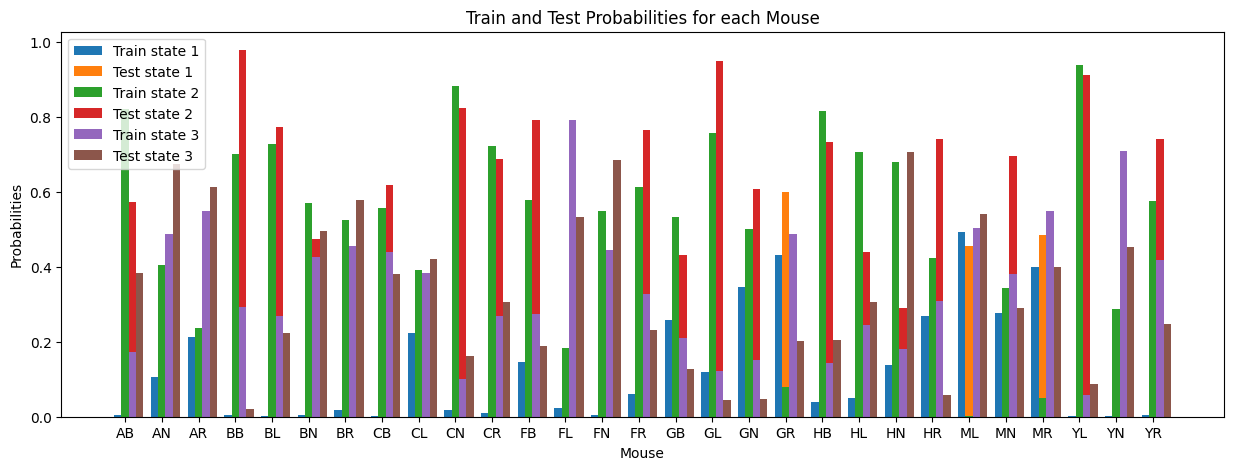

In [15]:
# Extracting data for plotting
mice = [entry['mouse'] for entry in mouse_probs_comparison]
train_probs = [entry['train_probs'] for entry in mouse_probs_comparison]
test_probs = [entry['test_probs'] for entry in mouse_probs_comparison]


num_mice = len(mice)
num_categories = len(train_probs[0])  
index = np.arange(num_mice)  # the x locations for the groups
bar_width = 0.2  
space_width = 4

# Plotting
fig, ax = plt.subplots(figsize=(15, 5))
for i in range(num_categories):
    offset = (i - (num_categories - 1) / 2) * bar_width  
    train_bars = ax.bar(index + offset, [train_probs[j][i] for j in range(num_mice)], bar_width, label=f'Train state {i+1}')
    test_bars = ax.bar(index + offset + bar_width, [test_probs[j][i] for j in range(num_mice)], bar_width, label=f'Test state {i+1}')

ax.set_xlabel('Mouse')
ax.set_ylabel('Probabilities')
ax.set_title('Train and Test Probabilities for each Mouse')
ax.set_xticks(index)
ax.set_xticklabels(mice)
ax.legend()

plt.show()

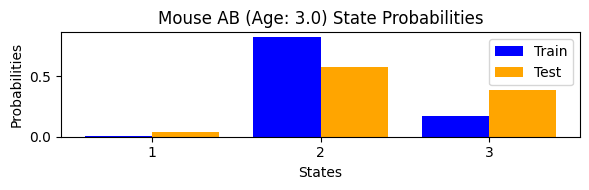

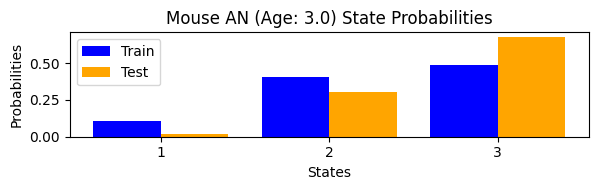

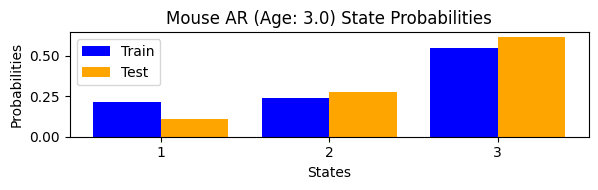

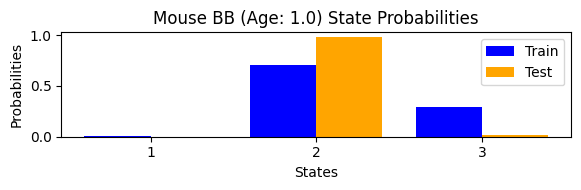

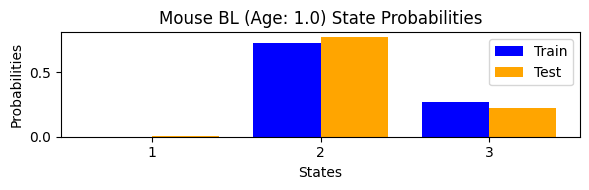

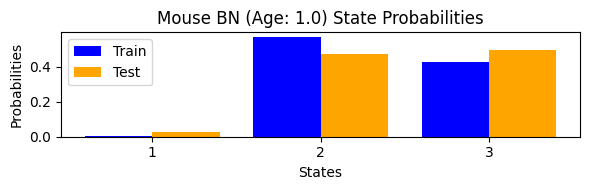

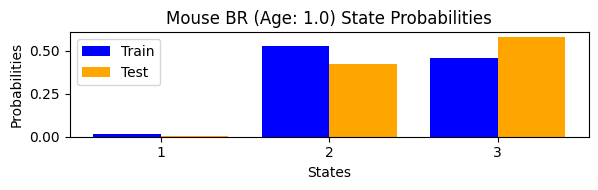

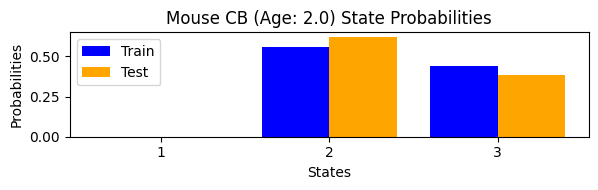

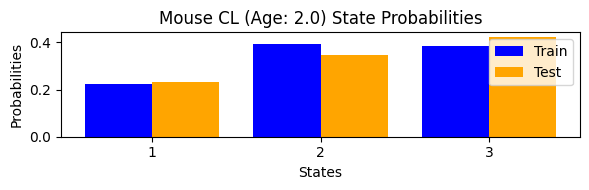

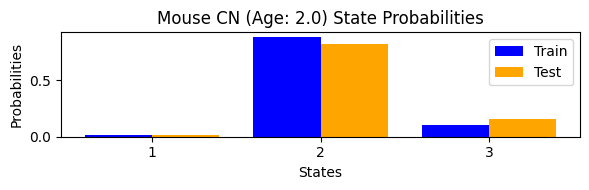

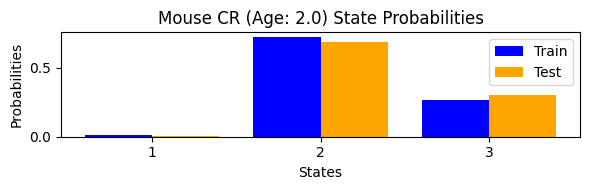

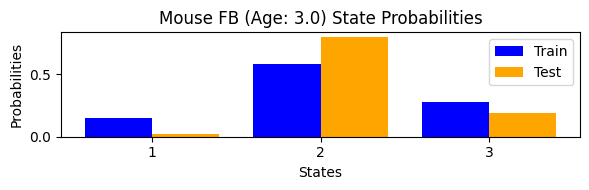

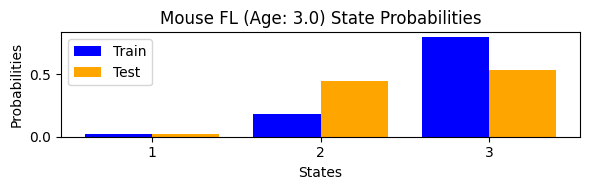

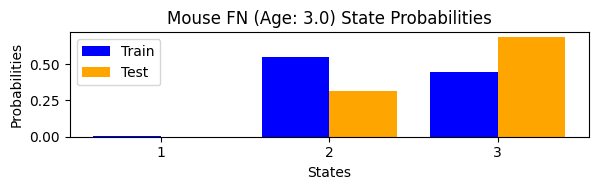

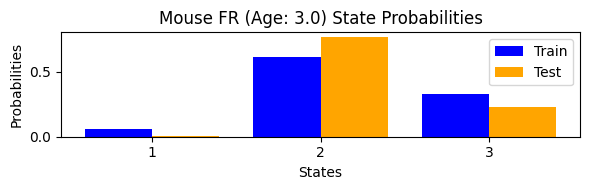

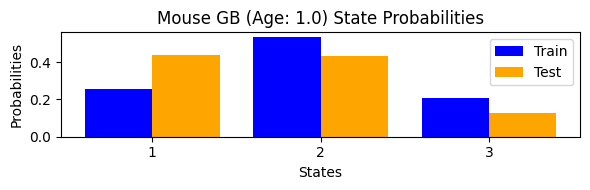

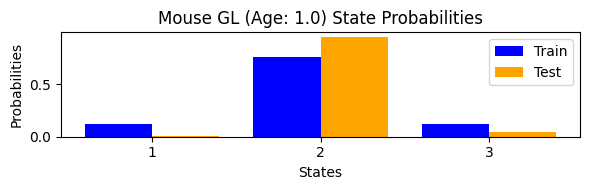

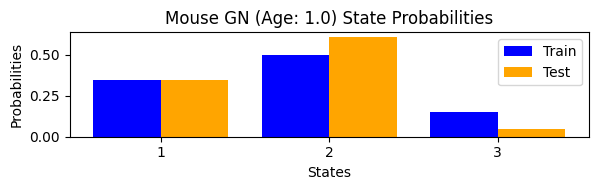

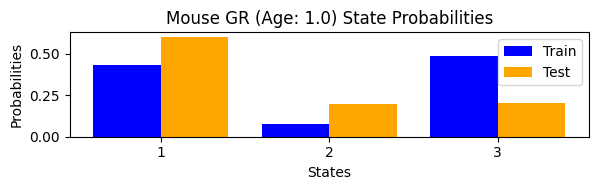

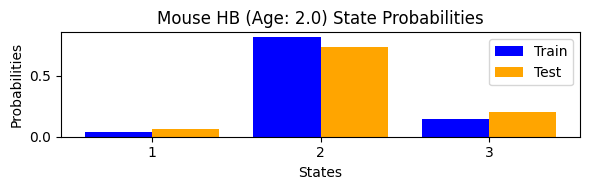

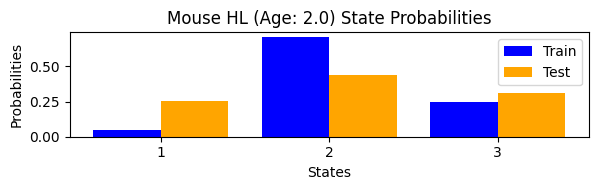

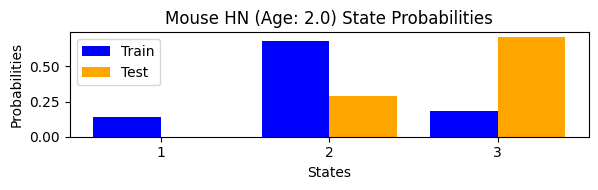

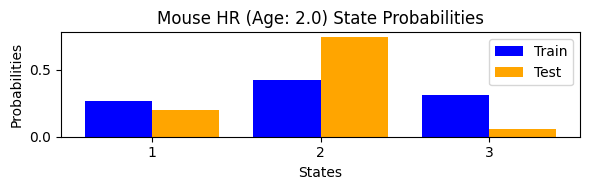

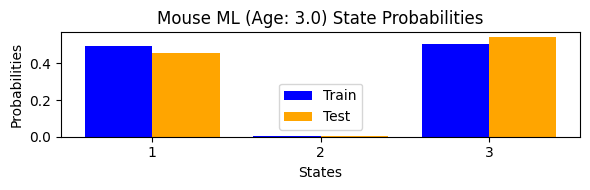

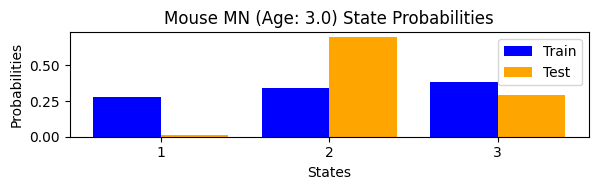

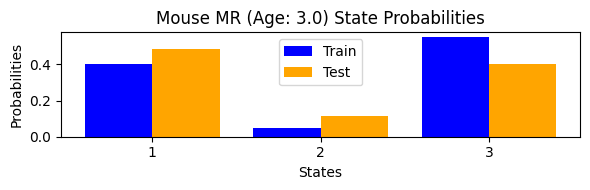

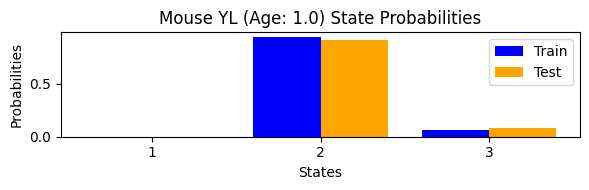

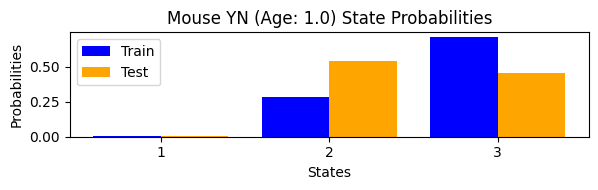

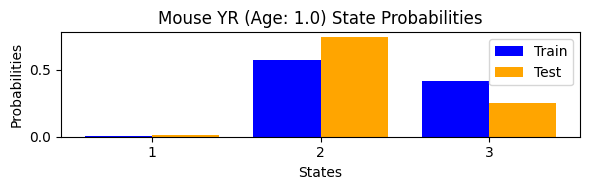

In [61]:
#Plot train and test state probabilities for each mouse
for mouse_train in mouse_state_probs_train:
    if mouse_train['mouse'] in test_mice_set:
        mouse_test = next((mouse for mouse in mouse_state_probs_test if mouse['mouse'] == mouse_train['mouse']), None)
        if mouse_test is not None and mouse_train['age'] == mouse_test['age']:
            mouse_id = mouse_train['mouse']
            age = mouse_train['age']
            train_probs = mouse_train['state_probs']
            test_probs = mouse_test['state_probs']
        qUtils.plot_train_test_probs(train_probs, test_probs, mouse_id, age)

In [55]:
# get train and test data for each animal model
animal_train_x = []
animal_test_x = []
animal_train_choices = []
animal_test_choices = []

for i in range(len(animal_models)):
    x_cols = animal_models[i]['model_params']['x_cols']
    for j, mouse in enumerate(animal_models[i]['model_list']):
        animal = animal_models[i]['model_list'][j]['mouse']
        num_states = animal_models[i]['model_params']['num_states'][0]
        train_data = animal_models[i]['data_splits']['train_ids'][j]
        test_data = animal_models[i]['data_splits']['test_ids'][j]
        train_data = filtered_data[filtered_data['Session ID'].isin(train_data)]
        test_data = filtered_data[filtered_data['Session ID'].isin(test_data)]
        animal_train_x.append({'mouse': animal,'num_states': num_states, 'data': train_data[x_cols].to_numpy()})
        animal_test_x.append({'mouse': animal,'num_states': num_states, 'data': test_data[x_cols].to_numpy()})
        animal_train_choices.append({'mouse': animal,'num_states': num_states, 'data': train_data['Decision'].to_numpy().reshape(-1, 1).astype(int)})
        animal_test_choices.append({'mouse': animal,'num_states': num_states, 'data': test_data['Decision'].to_numpy().reshape(-1, 1).astype(int)})

In [56]:
animal_train_states, animal_test_states = qUtils.predict_state(animal_train_x, animal_test_x, 
                                                               animal_train_choices, animal_test_choices, 
                                                               animal_models, multi_animal = True)

### Calculate prediction accuracy for each model

In [57]:
global_acc = qUtils.predict_choice(global_models, global_test_states, global_test_x, global_test_choices, accuracy=True, verbose=True)

Model with 0 state(s) has a test predictive accuracy of 0.8570024033209526
Model with 1 state(s) has a test predictive accuracy of 0.8572573009977423
Model with 2 state(s) has a test predictive accuracy of 0.8596424149734179
Model with 3 state(s) has a test predictive accuracy of 0.8578035103051489


In [58]:
animal_acc = qUtils.predict_choice(animal_models, animal_test_states, animal_test_x, animal_test_choices, accuracy=True, verbose=True, multi_animal=True)

Animal Model AB with 1 state(s) has a test predictive accuracy of 0.8808748255002327
Animal Model AN with 1 state(s) has a test predictive accuracy of 0.8460694698354662
Animal Model AR with 1 state(s) has a test predictive accuracy of 0.8307246376811595
Animal Model BB with 1 state(s) has a test predictive accuracy of 0.8940527766837337
Animal Model BL with 1 state(s) has a test predictive accuracy of 0.8727064220183486
Animal Model BN with 1 state(s) has a test predictive accuracy of 0.8393846153846154
Animal Model BR with 1 state(s) has a test predictive accuracy of 0.8581932773109243
Animal Model CB with 1 state(s) has a test predictive accuracy of 0.864090316977855
Animal Model CL with 1 state(s) has a test predictive accuracy of 0.899416255051639
Animal Model CN with 1 state(s) has a test predictive accuracy of 0.910761154855643
Animal Model CR with 1 state(s) has a test predictive accuracy of 0.8605328892589509
Animal Model FB with 1 state(s) has a test predictive accuracy of 0.

Text(0.5, 1.0, 'Global vs. Animal predictive accuracy')

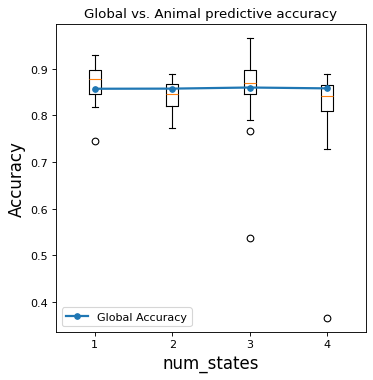

In [59]:
# group data by state
animal_grouped_data = {}
for item in animal_acc:
    mouse = item['num_states']
    if mouse not in animal_grouped_data:
        animal_grouped_data[mouse] = []
    animal_grouped_data[mouse].append(item)
    
#create box and whisker plot for accuracy of each state for each animal and overlay global accuracy
fig = plt.figure(figsize=(5, 5), dpi=80, facecolor='w', edgecolor='k')
for key in animal_grouped_data:
    data = [x['acc'] for x in animal_grouped_data[key]]
    plt.boxplot(data, positions=[key])
plt.plot(np.arange(1, len(global_acc) + 1), global_acc, marker='o', markersize=5, lw=2, label='Global Accuracy')  # shift indices by 1
plt.legend(loc="lower left")
plt.ylabel("Accuracy", fontsize=15)
plt.xlabel("num_states", fontsize=15)
plt.xticks(np.arange(1, 5))
plt.title('Global vs. Animal predictive accuracy')

In [22]:
globa_train_occupancy, global_test_occupancy = qUtils.pred_occupancy(global_train_states, 
                                                global_test_states, global_models)

1
1
2
2
3
3
4
4


In [23]:
animal_train_occupancy, animal_test_occupancy = qUtils.pred_occupancy(animal_train_states, 
                                                        animal_test_states, animal_models, 
                                                        multi_animal=True)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
2
3
2
3
3
2
3
3
3
3
3
3
1
3
3
3
3
3
3
3
3
2
3
3
3
3
3
4
3
4
4
4
4
3
4
3
4
3
4
4
4
4
3
4
4
4
4
3
4
4
3
4
4
4
3
4
4
4
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
2
3
2
3
3
2
3
3
3
3
3
3
1
3
3
3
3
3
3
3
3
2
3
3
3
3
3
4
3
4
4
4
4
3
4
3
4
3
4
4
4
4
3
4
4
4
4
3
4
4
3
4
4
4
3
4
4
4
1
1
1
1


In [ ]:
qUtils.plot_tmat(global_models, 1, 2, multi_animal=False)

In [ ]:
qUtils.plot_state_probs(2, (0, 2000), global_test_states, global_test_occupancy, as_occupancy=False)

## Fit selected glmhmm model to all data:
Now that we have selected the best model, we will fit it to all of the data and plot the results.

In [29]:
#Fetch saved model and model params
model_ind = 1
num_states = global_models[model_ind]['model_params']['num_states'][0]
model = global_models[model_ind]['model_list'][0]
x_cols = global_models[model_ind]['model_params']['x_cols']

#Make X and Y data
choices = filtered_data['Decision'].to_numpy().reshape(-1, 1).astype(int)
inpts = filtered_data[x_cols].to_numpy()

ll = model.fit(choices, inputs=inpts, method="em", num_em_iters=2000, initialize=False)

  0%|          | 0/100 [00:00<?, ?it/s]

In [30]:
#Get expected state probabilities
expected_states = model.expected_states(choices, inpts)

assert len(expected_states[0]) == len(choices)

In [31]:
#create new df with Mouse ID, Session ID, Age_Group and state sequence
temp_df = filtered_data.filter(['Session ID', 'Mouse ID', 'Age_Group', 'Trial'])
for j in range(num_states):
    temp_df['state' + str(j + 1)] = expected_states[0][:,j]

In [32]:
#for each unique mouse, average the state probabilities for each state
mice = temp_df['Mouse ID'].unique()
mouse_state_probs = []
for mouse in mice:
    mouse_df = temp_df[temp_df['Mouse ID'] == mouse]
    age = mouse_df['Age_Group'].unique()
    for a in age:
        age_df = mouse_df[mouse_df['Age_Group'] == a]
        state_probs = []
        for i in range(num_states):
            state_probs.append(np.mean(age_df['state' + str(i + 1)]))
        mouse_state_probs.append({'mouse': mouse, 'age': a, 'state_probs': state_probs})

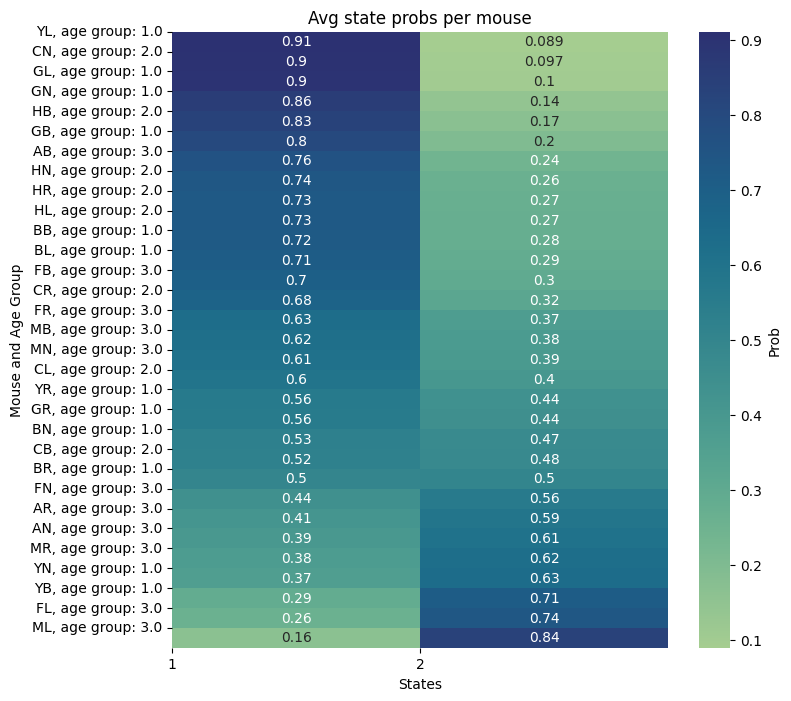

In [33]:
#make heatmap of state probabilities for each mouse
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

#make dataframe from mouse_state_probs
df = pd.DataFrame(mouse_state_probs)
df = df.sort_values(by=['age', 'mouse'])
df = df.reset_index(drop=True)
df_sorted = df.iloc[df['state_probs'].apply(lambda x: x[0]).argsort()[::-1]]

# Create y-tick labels with both mouse and age group
yticklabels = [f"{mouse}, age group: {age_group}" for mouse, age_group in zip(df_sorted['mouse'], df_sorted['age'])]

# Make heatmap
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(df_sorted['state_probs'].tolist(), cmap="crest", ax=ax, center=0.5, annot=True, cbar_kws={'label': 'Prob'}) #rocket
ax.set_yticks(np.arange(len(df_sorted['mouse'])))
ax.set_yticklabels(yticklabels, rotation=0)
ax.set_xticks(np.arange(num_states))
ax.set_xticklabels(np.arange(1, num_states + 1))
ax.set_xlabel('States')
ax.set_ylabel('Mouse and Age Group')
plt.title('Avg state probs per mouse')
plt.show()


## Data exploration

Text(0.5, 1.0, 'Total interaction per mouse - sorted by state 1 probability')

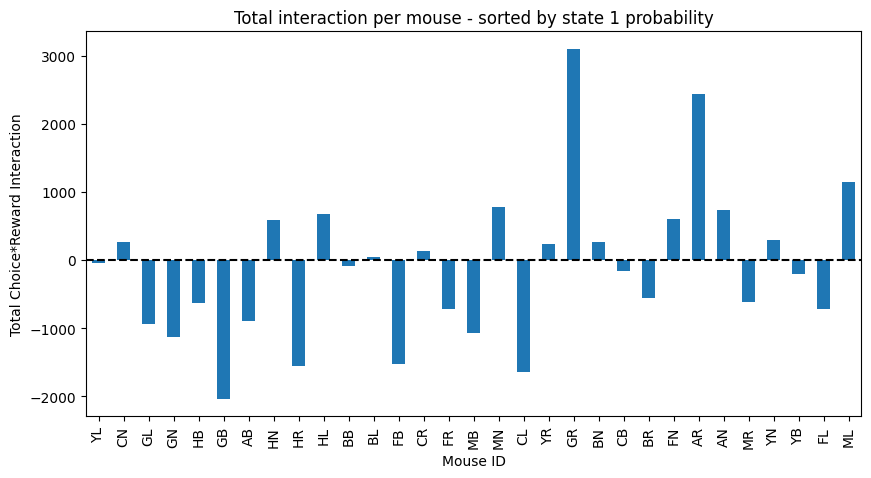

In [41]:
# add up rewards for each mouse and plot
interaction = filtered_data.groupby('Mouse ID')['1_ChoiceReward'].sum()
interaction = interaction[df_sorted['mouse']]
interaction.plot(kind='bar', figsize=(10, 5))
plt.axhline(y=0, color='black', linestyle='--')
plt.ylabel('Total Choice*Reward Interaction')
plt.title('Total interaction per mouse - sorted by state 1 probability')

Text(0.5, 1.0, 'Total 0s, 1s, -1s per mouse')

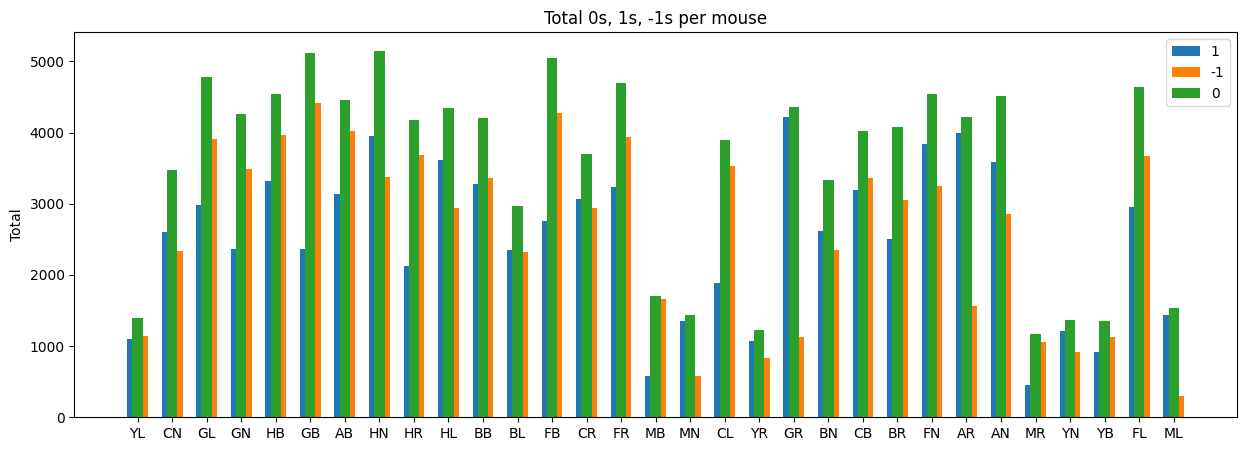

In [45]:
#for each mouse, count all the zeros in the 1_ChoiceReward column
zeros = filtered_data.groupby('Mouse ID')['1_ChoiceReward'].apply(lambda x: (x == 0).sum())
ones = filtered_data.groupby('Mouse ID')['1_ChoiceReward'].apply(lambda x: (x == 1).sum())
neg_ones = filtered_data.groupby('Mouse ID')['1_ChoiceReward'].apply(lambda x: (x == -1).sum())

#sort by df_sorted index
zeros = zeros[df_sorted['mouse']]
ones = ones[df_sorted['mouse']]
neg_ones = neg_ones[df_sorted['mouse']]


#create paired bar plot for each mouse showing the number of 1s and -1s
fig, ax = plt.subplots(figsize=(15, 5))
x = np.arange(len(ones))
bar_width = 0.3
ax.bar(x - bar_width/2, ones, bar_width, label='1')
ax.bar(x + bar_width/2, neg_ones, bar_width, label='-1')
ax.bar(x, zeros, bar_width, label='0')
ax.set_xticks(x)
ax.set_xticklabels(ones.index)
ax.legend()
plt.ylabel('Total')
plt.title('Total 0s, 1s, -1s per mouse')